In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from dpp.data import load_from_kaggle


/Users/ebbykuriakose/Desktop/Project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dataset_link = "gagandeep16/car-sales" # replace with your dataset link from Kaggle 
destination = "../data/raw"
dataset_name = dataset_link.split("/")[-1]

files = load_from_kaggle(
    dataset_link=dataset_link, 
    destination=destination,
    )

Destination directory '../data/raw/car-sales' already exists with files. Skipping download (replace=False).


In [5]:
files

['Car_sales.csv']

In [6]:
df = pd.read_csv("/".join(["../data/raw/", dataset_name, files[0]]))
df.head()

,Manufacturer,Model,Sales_in_thousands,__year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
0,Acura,Integra,16.919,16.360,Passenger,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280150
1,Acura,TL,39.384,19.875,Passenger,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.370778
2,Acura,CL,14.114,18.225,Passenger,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,1/4/2012,NaN
3,Acura,RL,8.588,29.725,Passenger,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,3/10/2011,91.389779
4,Audi,A4,20.397,22.255,Passenger,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,10/8/2011,62.777639


In [7]:
display(
    "Shape",
    df.shape,
    "Description",
    df.describe().round(2),
    "Duplicates",
    df.duplicated().sum(),
)


pd.DataFrame(
    {
        "Data Types": df.dtypes,
        "Missing Values": df.isnull().sum(),
        "Unique Values": df.nunique(),
        "Sample Values": [df[col].sample(3).tolist() for col in df.columns]
    })


'Shape'

(157, 16)

'Description'

,Sales_in_thousands,__year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
count,157.00,121.00,155.00,156.00,156.00,156.00,156.00,156.00,155.00,156.00,154.00,155.00
mean,53.00,18.07,27.39,3.06,185.95,107.49,71.15,187.34,3.38,17.95,23.84,77.04
std,68.03,11.45,14.35,1.04,56.70,7.64,3.45,13.43,0.63,3.89,4.28,25.14
min,0.11,5.16,9.24,1.00,55.00,92.60,62.60,149.40,1.90,10.30,15.00,23.28
25%,14.11,11.26,18.02,2.30,149.50,103.00,68.40,177.58,2.97,15.80,21.00,60.41
50%,29.45,14.18,22.80,3.00,177.50,107.00,70.55,187.90,3.34,17.20,24.00,72.03
75%,67.96,19.88,31.95,3.58,215.00,112.20,73.43,196.12,3.80,19.58,26.00,89.41
max,540.56,67.55,85.50,8.00,450.00,138.70,79.90,224.50,5.57,32.00,45.00,188.14


'Duplicates'

np.int64(0)

,Data Types,Missing Values,Unique Values,Sample Values
Manufacturer,object,0,30,"[Hyundai, Ford, Porsche]"
Model,object,0,156,"[Galant, Forester, SC]"
Sales_in_thousands,float64,0,157,"[42.643, 1.112, 9.231]"
__year_resale_value,float64,36,117,"[16.575, nan, 41.45]"
Vehicle_type,object,0,2,"[Passenger, Passenger, Passenger]"
Price_in_thousands,float64,2,152,"[nan, 49.9, 41.43]"
Engine_size,float64,1,31,"[3.2, 4.0, 2.0]"
Horsepower,float64,1,66,"[140.0, nan, 170.0]"
Wheelbase,float64,1,88,"[106.5, 107.3, 101.2]"
Width,float64,1,78,"[70.6, 74.1, 72.7]"


In [8]:
#Data Cleaning
# Renaming __year_resale_value column
if "__year_resale_value" in df.columns:
    df.rename(columns={"__year_resale_value": "Year_resale_value"}, inplace=True)

In [9]:
# Modifying data types of object columns to categorical columns

category_col = ["Manufacturer","Model","Vehicle_type"]
for col in category_col:
    df[col] = df[col].astype("category")

df["Latest_Launch"] = pd.to_datetime(df["Latest_Launch"], errors = "coerce")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Manufacturer        157 non-null    category      
 1   Model               157 non-null    category      
 2   Sales_in_thousands  157 non-null    float64       
 3   Year_resale_value   121 non-null    float64       
 4   Vehicle_type        157 non-null    category      
 5   Price_in_thousands  155 non-null    float64       
 6   Engine_size         156 non-null    float64       
 7   Horsepower          156 non-null    float64       
 8   Wheelbase           156 non-null    float64       
 9   Width               156 non-null    float64       
 10  Length              156 non-null    float64       
 11  Curb_weight         155 non-null    float64       
 12  Fuel_capacity       156 non-null    float64       
 13  Fuel_efficiency     154 non-null    float64       

In [11]:
# Handling missing values in year_resale_value column
df["Year_resale_value"] = df["Year_resale_value"].fillna(df["Year_resale_value"].median())

In [12]:
new_df = df[df["Price_in_thousands"].isna()]
new_df

,Manufacturer,Model,Sales_in_thousands,Year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
2,Acura,CL,14.114,18.225,Passenger,NaN,3.2,225.0,106.9,70.6,192.0,3.47,17.2,26.0,2012-01-04,NaN
33,Chrysler,Town & Country,53.480,19.540,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-07-13,NaN


In [13]:
# Drop Chrysler Town & Country row
df = df.drop(index = 33)

# Fill Acura CL missing values with median
df["Price_in_thousands"] = df["Price_in_thousands"].fillna(df["Price_in_thousands"].median())
df["Power_perf_factor"] = df["Power_perf_factor"].fillna(df["Power_perf_factor"].median())


In [14]:
new_df = df[df["Curb_weight"].isna()]
new_df

,Manufacturer,Model,Sales_in_thousands,Year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
15,Cadillac,Seville,15.943,27.1,Passenger,44.475,4.6,275.0,112.2,75.0,201.0,NaN,18.5,22.0,2011-04-29,115.621358


In [15]:
# Linear Regression model to replace Curb_weight value

# Choose predictors for Curb_weight
features = ["Length", "Width", "Engine_size", "Horsepower", "Wheelbase", "Fuel_capacity"]

# Split data into rows with and without Curb_weight
train_data = df[df["Curb_weight"].notnull()]
test_data = df[df["Curb_weight"].isnull()]

# Save indices of missing rows
missing_idx = test_data.index

# Prepare training data
X_train = train_data[features]
y_train = train_data["Curb_weight"]

# Train regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict missing Curb_weight
X_test = test_data[features]
predicted_values = model.predict(X_test)

# Assign predictions back
df.loc[missing_idx, "Curb_weight"] = predicted_values

# Print imputed rows horizontally
print("Rows imputed using regression:")
display(df.loc[missing_idx])


Rows imputed using regression:


,Manufacturer,Model,Sales_in_thousands,Year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
15,Cadillac,Seville,15.943,27.1,Passenger,44.475,4.6,275.0,112.2,75.0,201.0,3.816319,18.5,22.0,2011-04-29,115.621358


In [16]:
# Curb_weight replaced using median
# Create a copy of the original DataFrame to hold the results
#df_median = df.copy()

# Calculate the median of the existing (notnull) 'Curb_weight' values.
#df_median["Curb_weight"] = df_median["Curb_weight"].fillna(df_median["Curb_weight"].median())

# Display the rows that were imputed
#df_median.loc[[15]]

In [17]:
new_df = df[df["Fuel_efficiency"].isna()]
new_df

,Manufacturer,Model,Sales_in_thousands,Year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
38,Dodge,Intrepid,88.028,12.275,Passenger,22.505,2.7,202.0,113.0,74.7,203.7,3.489,17.0,NaN,2012-06-02,80.831470
109,Oldsmobile,Intrigue,38.554,14.180,Passenger,24.150,3.5,215.0,109.0,73.6,195.9,3.455,18.0,NaN,2011-04-01,86.272523


In [18]:
# Choose predictors for Fuel_efficiency
features = ["Engine_size", "Horsepower", "Curb_weight"]

# Split data into rows with and without Fuel_efficiency
train_data = df[df["Fuel_efficiency"].notnull()]
test_data  = df[df["Fuel_efficiency"].isnull()]

# Save indices of missing rows
missing_idx = test_data.index

# Prepare training data
X_train = train_data[features]
y_train = train_data["Fuel_efficiency"]

# Train regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict missing Fuel_efficiency values
X_test = test_data[features]
predicted_values = model.predict(X_test)

# Assign predictions back
df.loc[missing_idx, "Fuel_efficiency"] = predicted_values

# Print imputed rows horizontally
print("Rows imputed using regression:")
display(df.loc[missing_idx])

Rows imputed using regression:


,Manufacturer,Model,Sales_in_thousands,Year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
38,Dodge,Intrepid,88.028,12.275,Passenger,22.505,2.7,202.0,113.0,74.7,203.7,3.489,17.0,23.674701,2012-06-02,80.831470
109,Oldsmobile,Intrigue,38.554,14.180,Passenger,24.150,3.5,215.0,109.0,73.6,195.9,3.455,18.0,23.028418,2011-04-01,86.272523


In [19]:
display(df.describe().round(2))

,Sales_in_thousands,Year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
count,156.00,156.00,156.00,156.00,156.00,156.00,156.00,156.00,156.00,156.00,156.00,156,156.00
mean,52.99,17.17,27.36,3.06,185.95,107.49,71.15,187.34,3.38,17.95,23.84,2011-12-04 16:36:55.384615424,77.01
min,0.11,5.16,9.24,1.00,55.00,92.60,62.60,149.40,1.90,10.30,15.00,2008-02-13 00:00:00,23.28
25%,14.04,12.53,18.08,2.30,149.50,103.00,68.40,177.58,2.97,15.80,21.00,2011-07-04 18:00:00,60.57
50%,29.21,14.18,22.80,3.00,177.50,107.00,70.55,187.90,3.36,17.20,24.00,2011-12-11 00:00:00,72.03
75%,68.07,17.89,31.94,3.58,215.00,112.20,73.43,196.12,3.82,19.58,26.00,2012-06-02 12:00:00,89.41
max,540.56,67.55,85.50,8.00,450.00,138.70,79.90,224.50,5.57,32.00,45.00,2012-12-29 00:00:00,188.14
std,68.25,10.21,14.31,1.04,56.70,7.64,3.45,13.43,0.63,3.89,4.26,NaN,25.06


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, 0 to 156
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Manufacturer        156 non-null    category      
 1   Model               156 non-null    category      
 2   Sales_in_thousands  156 non-null    float64       
 3   Year_resale_value   156 non-null    float64       
 4   Vehicle_type        156 non-null    category      
 5   Price_in_thousands  156 non-null    float64       
 6   Engine_size         156 non-null    float64       
 7   Horsepower          156 non-null    float64       
 8   Wheelbase           156 non-null    float64       
 9   Width               156 non-null    float64       
 10  Length              156 non-null    float64       
 11  Curb_weight         156 non-null    float64       
 12  Fuel_capacity       156 non-null    float64       
 13  Fuel_efficiency     156 non-null    float64       
 14 


Column: Sales_in_thousands
Skewness: 3.40
Highly right-skewed


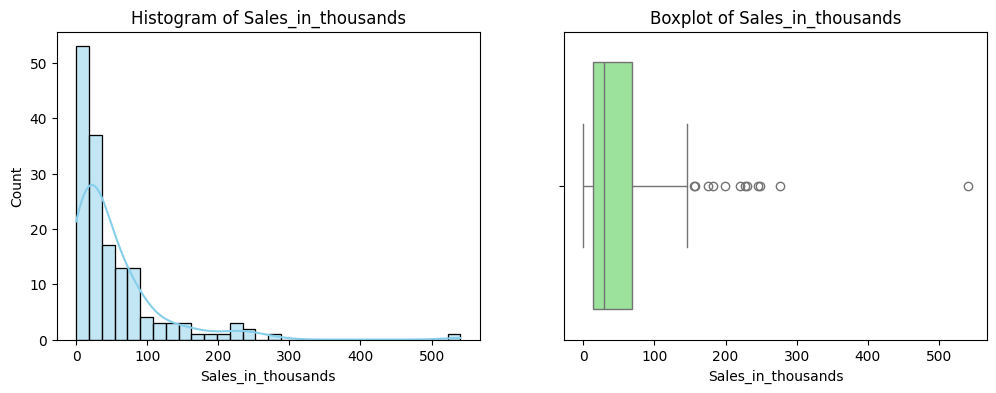


Column: Year_resale_value
Skewness: 2.76
Highly right-skewed


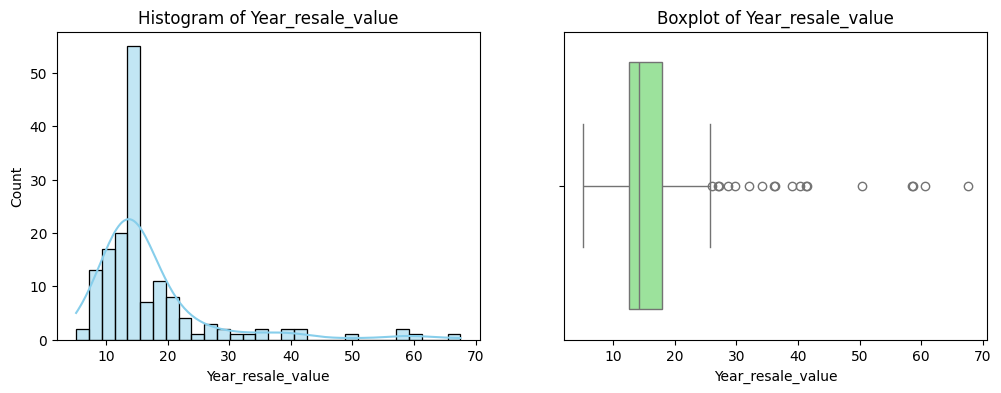


Column: Price_in_thousands
Skewness: 1.78
Highly right-skewed


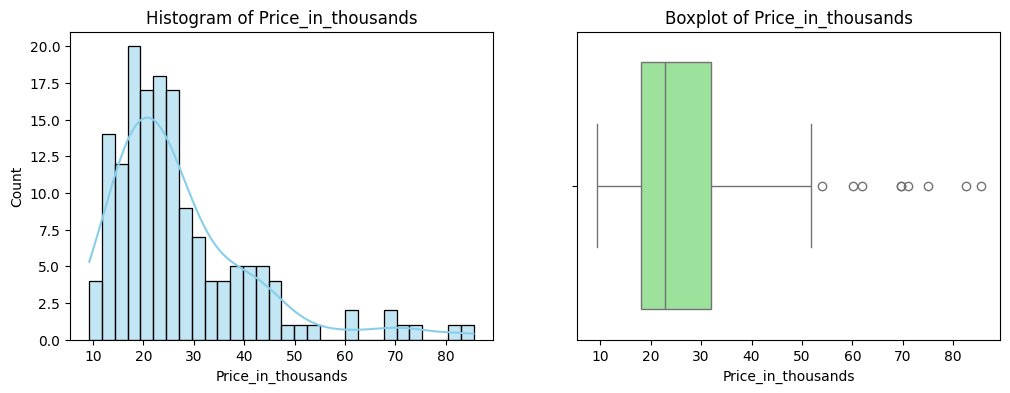


Column: Engine_size
Skewness: 1.10
Highly right-skewed


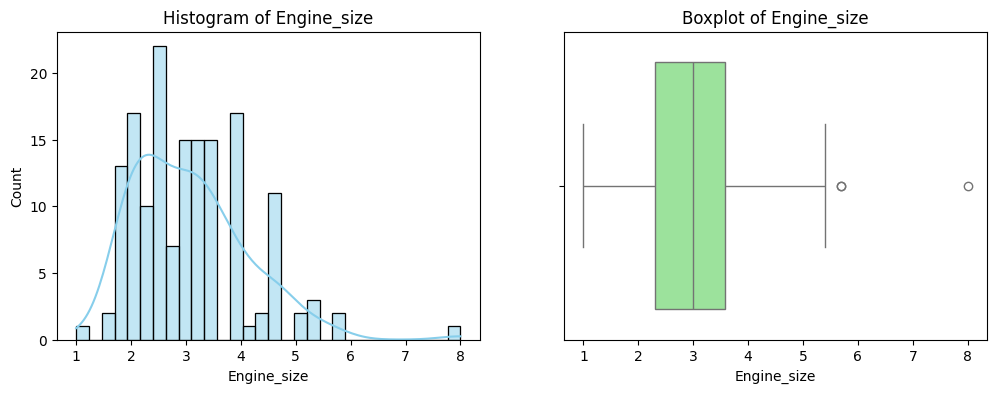


Column: Horsepower
Skewness: 1.00
Highly right-skewed


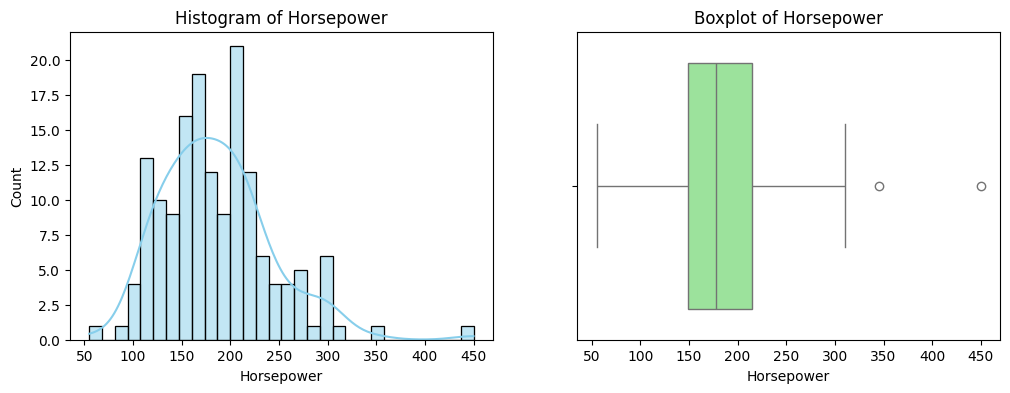


Column: Wheelbase
Skewness: 0.97
Moderately right-skewed


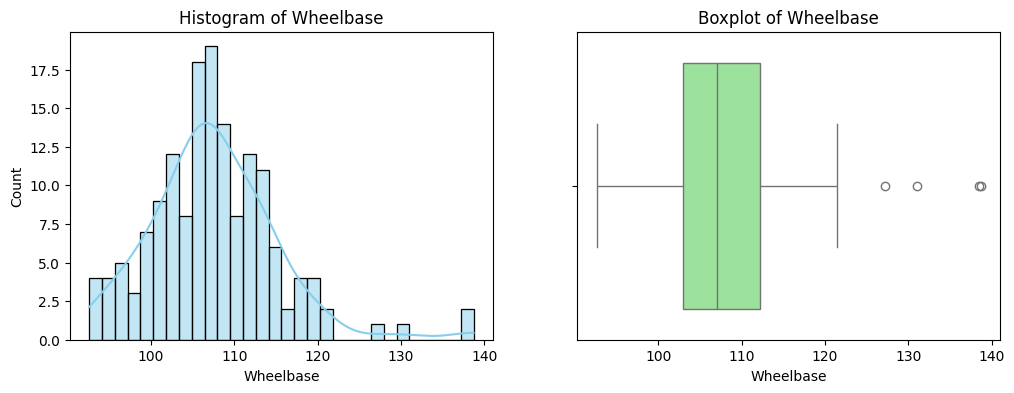


Column: Width
Skewness: 0.48
Approximately symmetric


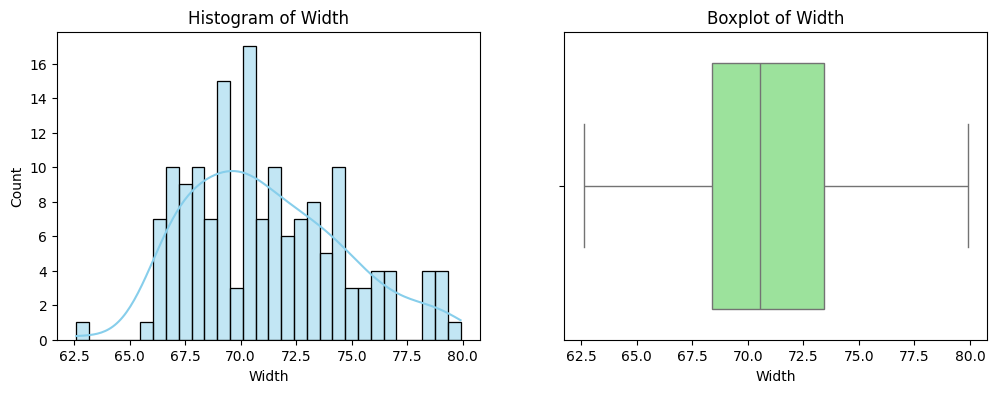


Column: Length
Skewness: -0.06
Approximately symmetric


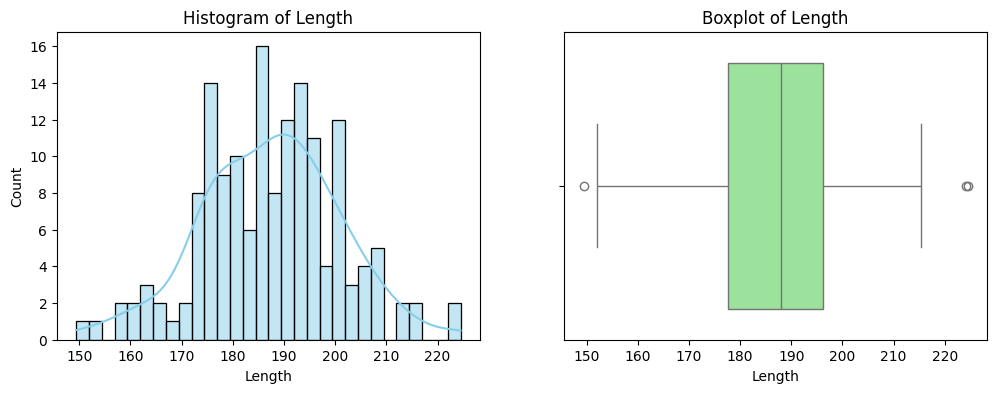


Column: Curb_weight
Skewness: 0.70
Moderately right-skewed


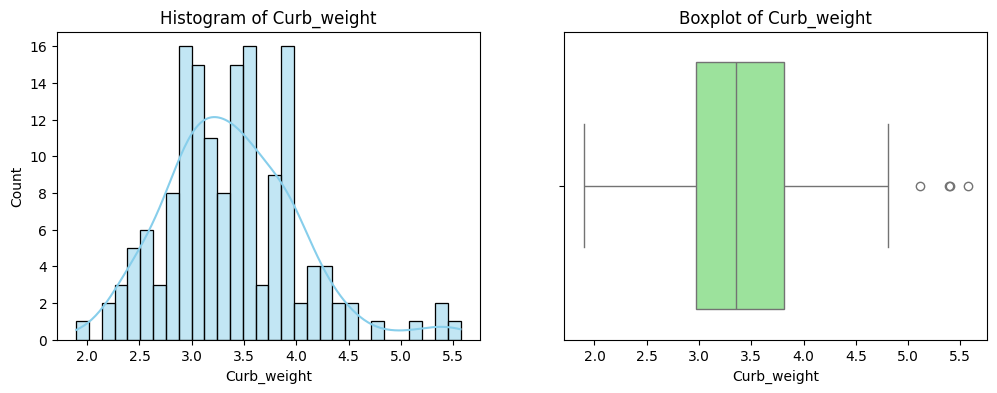


Column: Fuel_capacity
Skewness: 1.14
Highly right-skewed


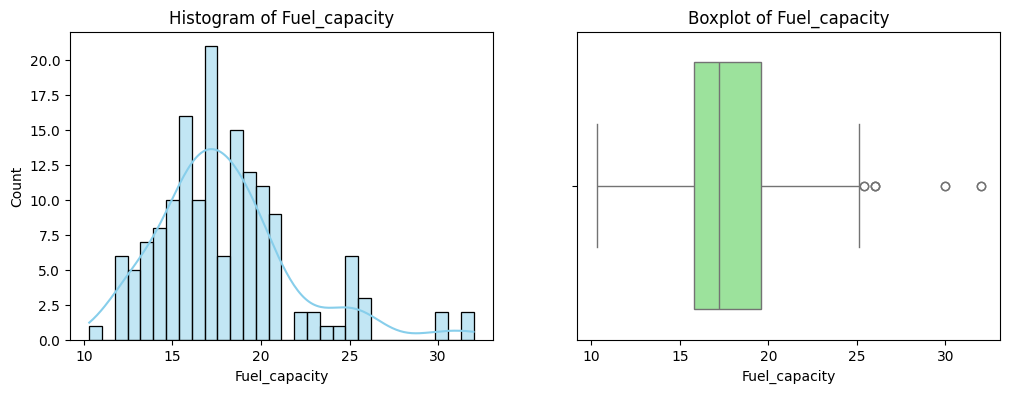


Column: Fuel_efficiency
Skewness: 0.70
Moderately right-skewed


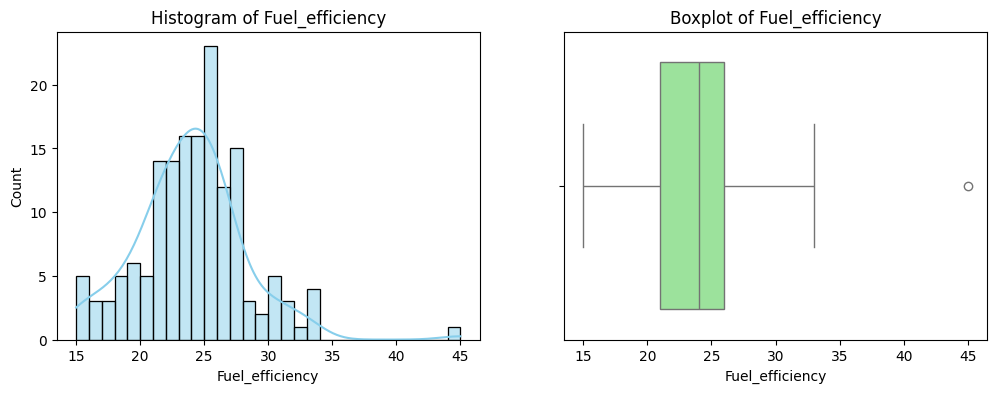


Column: Power_perf_factor
Skewness: 1.08
Highly right-skewed


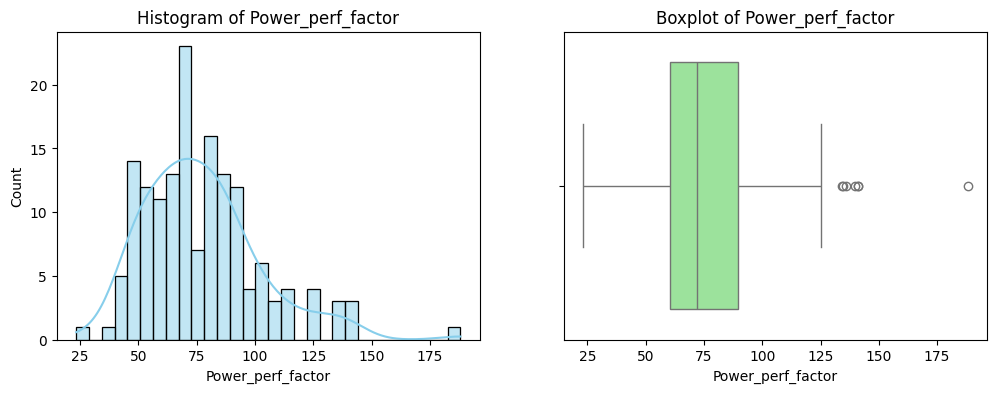

In [21]:
# Numeric Columns Analysis
numeric_cols = df.select_dtypes(include=np.number).columns

for col in numeric_cols:
    skewness = df[col].skew()

    print(f"\nColumn: {col}")
    print(f"Skewness: {skewness:.2f}")
    
    if skewness > 1:
        print("Highly right-skewed")
    elif skewness > 0.5:
        print("Moderately right-skewed")
    elif skewness < -1:
        print("Highly left-skewed")
    elif skewness < -0.5:
        print("Moderately left-skewed")
    else:
        print("Approximately symmetric")
    
    plt.figure(figsize=(12,4))
    
    # Histogram with KDE
    plt.subplot(1,2,1)
    sns.histplot(df[col], bins=30, kde=True, color='skyblue')
    plt.title(f"Histogram of {col}")
    
    # Boxplot
    plt.subplot(1,2,2)
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f"Boxplot of {col}")
    
    plt.show()


In [22]:
# Categorical Feature Analysis
manufacturer_count = df['Manufacturer'].value_counts()
print("Manufacturer counts:\n",manufacturer_count)

vehicle_type_count = df['Vehicle_type'].value_counts()
print("Vehicle type counts:\n",vehicle_type_count)


Manufacturer counts:
 Manufacturer
Ford          11
Dodge         11
Chevrolet      9
Mercedes-B     9
Toyota         9
Nissan         7
Mitsubishi     7
Pontiac        6
Mercury        6
Oldsmobile     6
Lexus          6
Chrysler       6
Volvo          6
Volkswagen     6
Cadillac       5
Honda          5
Saturn         5
Plymouth       4
Buick          4
Acura          4
Audi           3
BMW            3
Lincoln        3
Porsche        3
Jeep           3
Hyundai        3
Saab           2
Subaru         2
Jaguar         1
Infiniti       1
Name: count, dtype: int64
Vehicle type counts:
 Vehicle_type
Passenger    116
Car           40
Name: count, dtype: int64


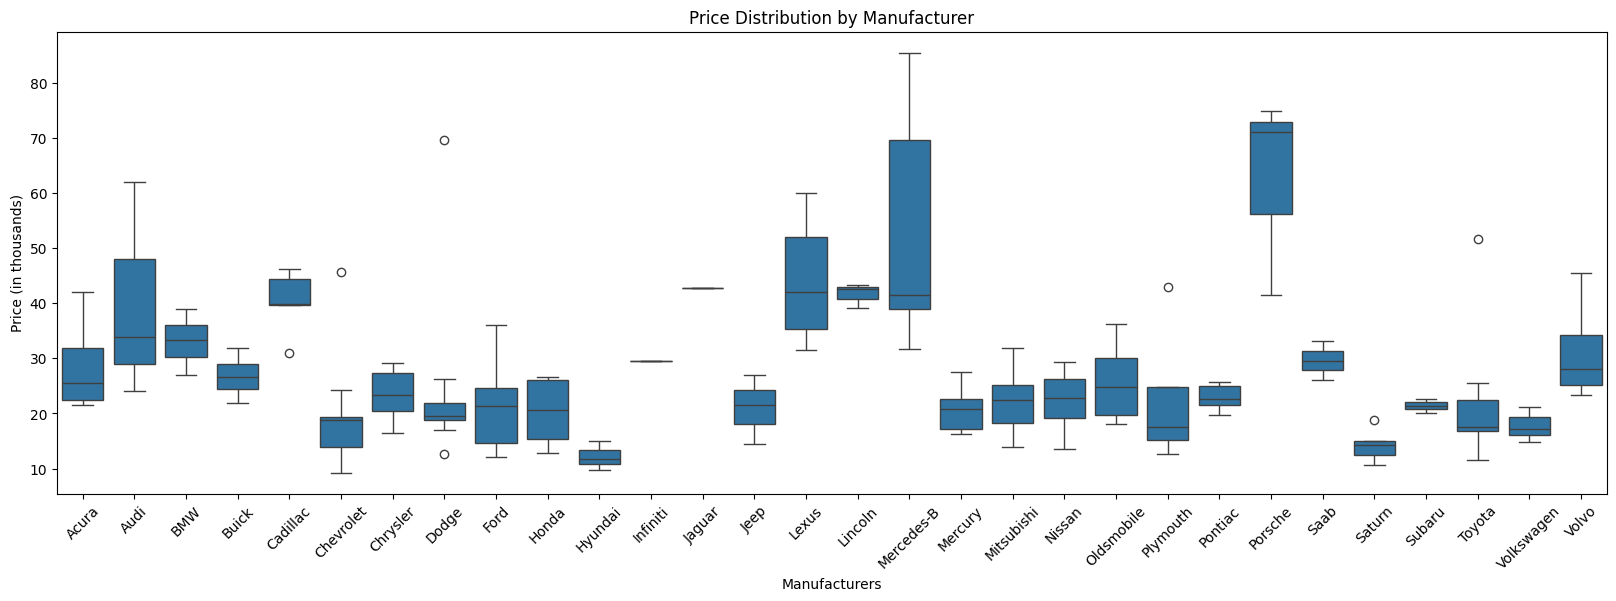

/var/folders/6k/b0rqkgcn77g39rb5g8zn55zc0000gn/T/ipykernel_42036/3861153316.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Manufacturer", y="Price_in_thousands", order=order, errorbar=None,palette='viridis')


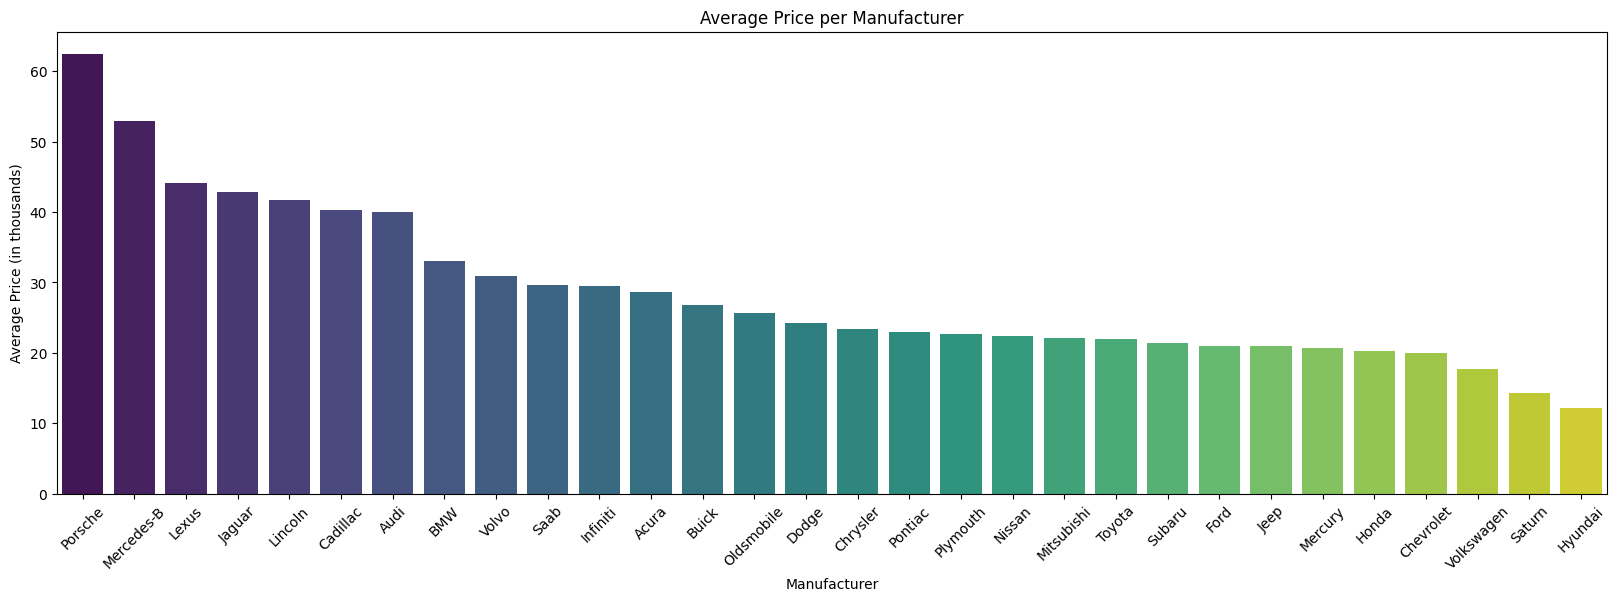

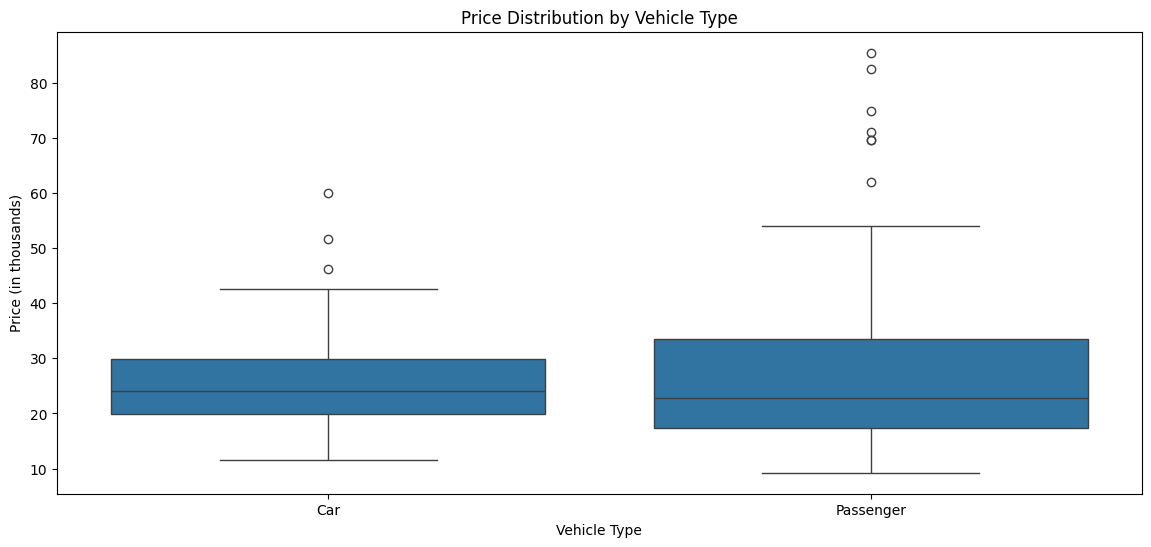

/var/folders/6k/b0rqkgcn77g39rb5g8zn55zc0000gn/T/ipykernel_42036/3861153316.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Vehicle_type', y='Price_in_thousands', data=df, errorbar=None, palette='viridis' )


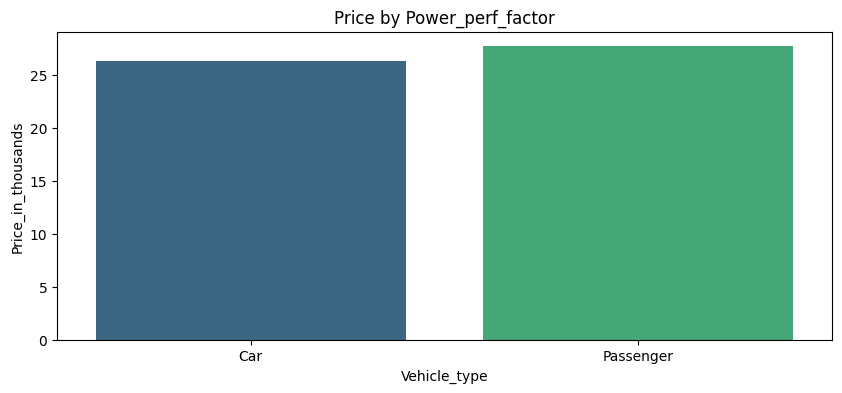


Insights:
1. Car Makes with Higher Prices:
   - Sorted barplot shows which manufacturers are more expensive on average.
   - Brands on the left (higher bars) tend to have higher prices.
2. Vehicle Type vs Price:
   - Boxplot shows that SUVs, Sports, and Luxury cars generally have higher prices than Sedans or Hatchbacks.
3. Additional Insight:
   - Vehicle type has a clear effect on price; price distribution varies significantly between types.


In [ ]:
# Categorical Columns Analysis

# Price Analysis (Categorical Features)
# Does Manufacturer significantly influence Price

# Manufacturer vs Price (Boxplot)
plt.figure(figsize=(20,6))
sns.boxplot(x="Manufacturer", y="Price_in_thousands", data=df)
plt.xticks(rotation=45)
plt.title("Price Distribution by Manufacturer")
plt.xlabel("Manufacturers")
plt.ylabel("Price (in thousands)")
plt.show()

# Which manufacturer tends to have the highest prices
# Average Price per Manufacturer (Barplot)
plt.figure(figsize=(20,6))

# Get the order of manufacturers sorted by mean price
order = df.groupby("Manufacturer", observed=True)["Price_in_thousands"].mean().sort_values(ascending=False).index

# Plot with sorted order
sns.barplot(data=df, x="Manufacturer", y="Price_in_thousands", order=order, errorbar=None,palette='viridis')
plt.xticks(rotation=45)
plt.title("Average Price per Manufacturer")
plt.xlabel("Manufacturer")
plt.ylabel("Average Price (in thousands)")
plt.show()

# Does Vehicle type affect Price
# Vehicle Type vs Price (Boxplot)
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x="Vehicle_type", y="Price_in_thousands")
plt.xticks()
plt.title("Price Distribution by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Price (in thousands)")
plt.show()

# Vehicle Type vs Price (Barplot)
plt.figure(figsize=(10,4))
sns.barplot(x='Vehicle_type', y='Price_in_thousands', data=df, errorbar=None, palette='viridis' )
plt.title(f"Mean Price by Vehicle Type")
plt.show()

# Insights / Answers

print("\nInsights:")
print("1. Car Makes with Higher Prices:")
print("   - Sorted barplot shows which manufacturers are more expensive on average.")
print("   - Brands on the left (higher bars) tend to have higher prices.")
print("2. Vehicle Type vs Price:")
print("   - Boxplot shows that SUVs, Sports, and Luxury cars generally have higher prices than Sedans or Hatchbacks.")
print("3. Additional Insight:")
print("   - Vehicle type has a clear effect on price; price distribution varies significantly between types.")


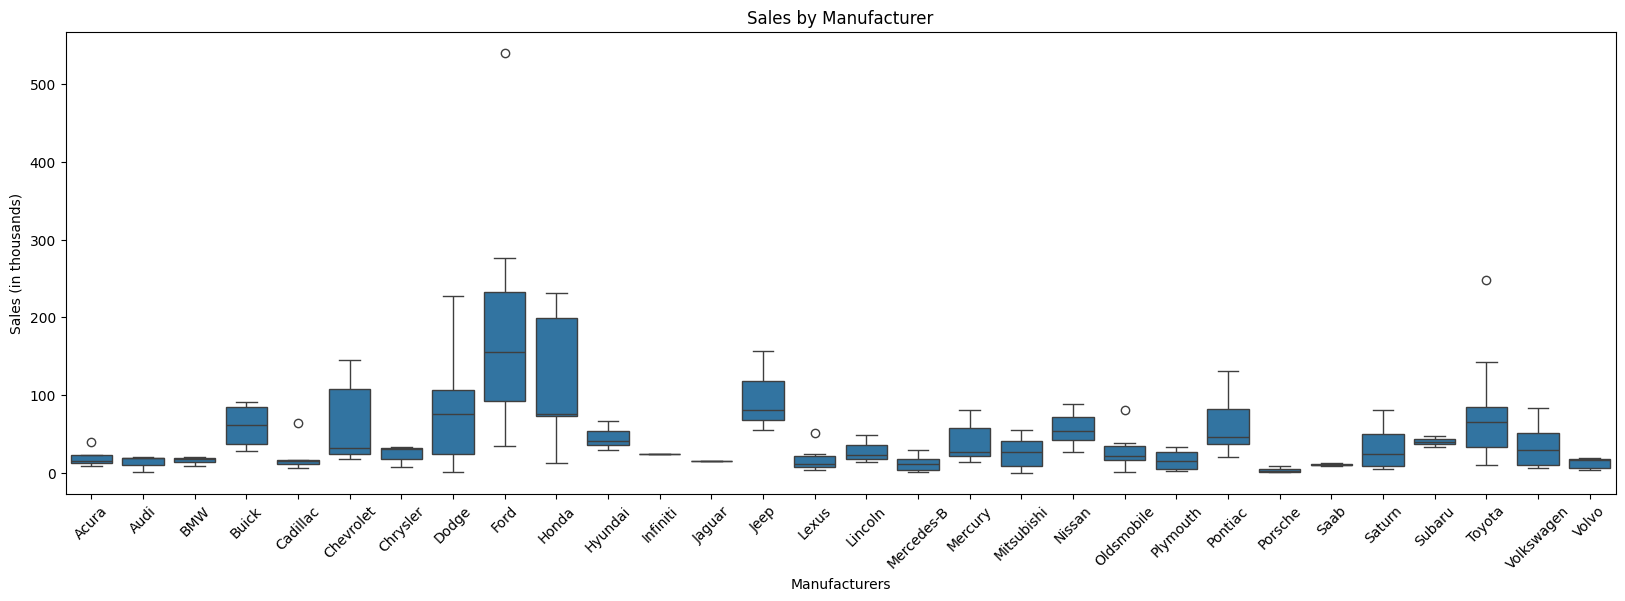

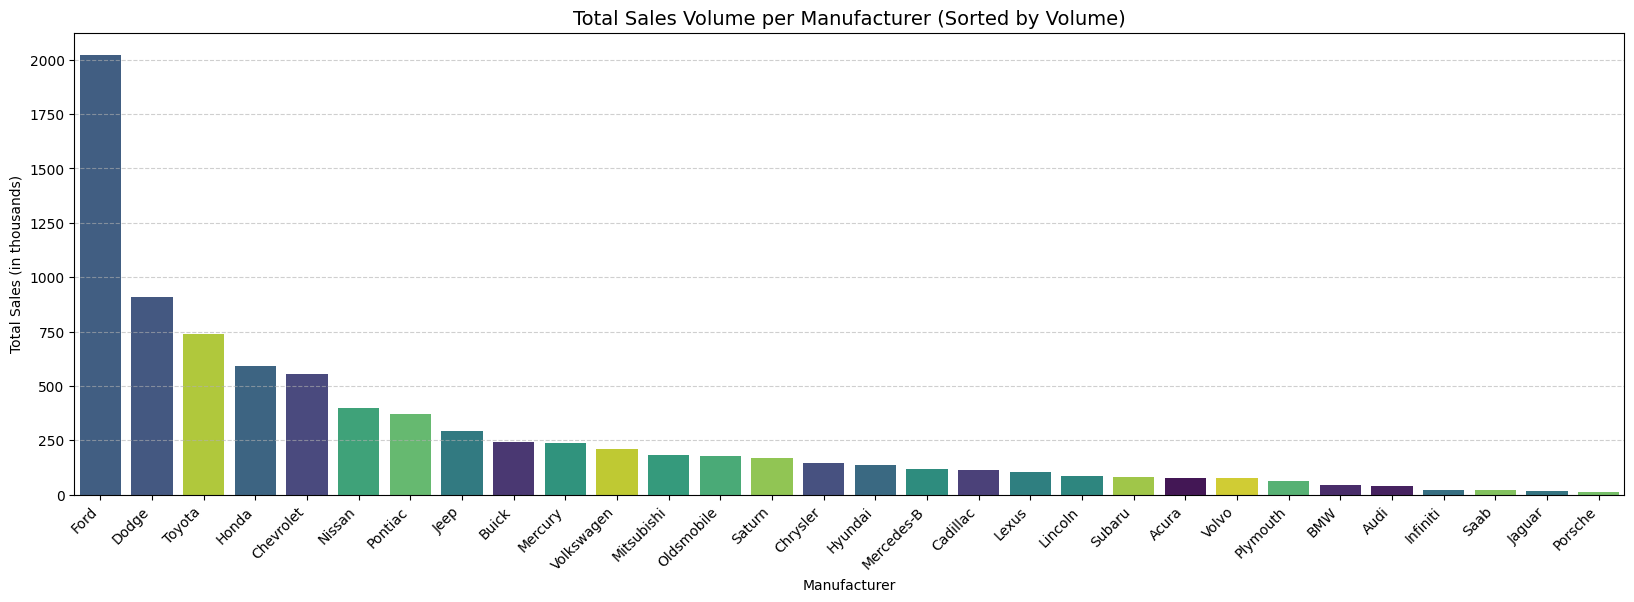

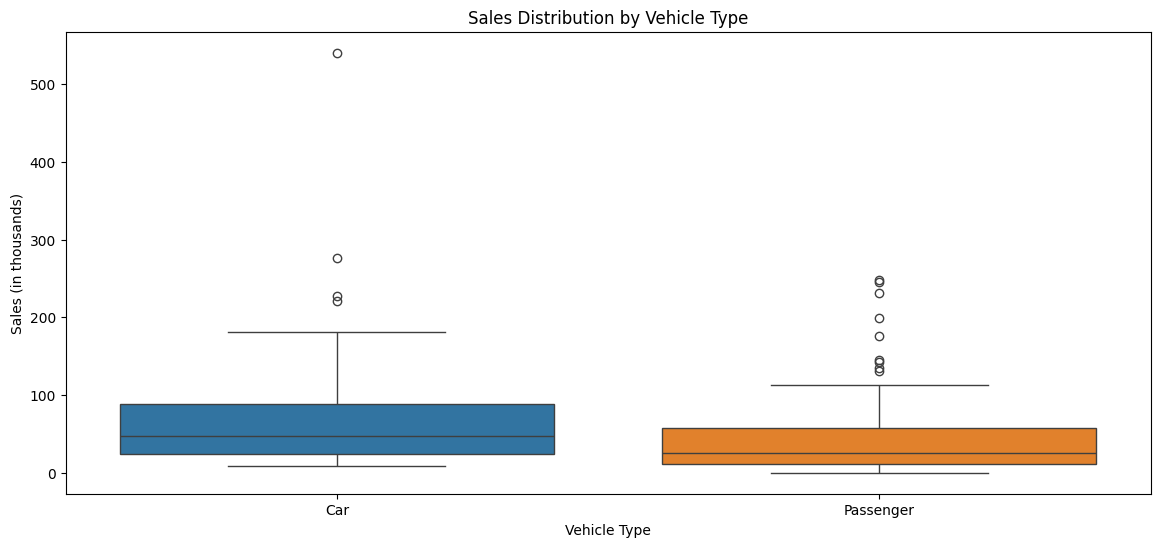

/var/folders/6k/b0rqkgcn77g39rb5g8zn55zc0000gn/T/ipykernel_42036/3225657219.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Vehicle_type', y='Sales_in_thousands', data=df, errorbar=None, palette='viridis' )


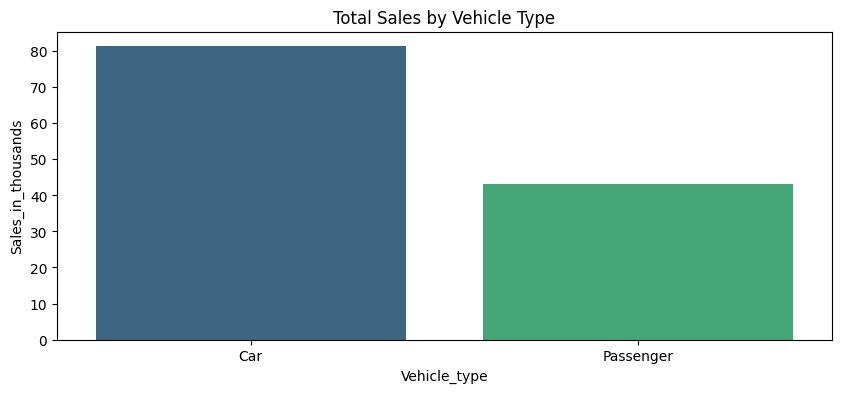

In [ ]:
# Sales Analysis (Categorical Features)
# Does Manufacturer significantly influence Sales

# Manufacturer vs Sales (Boxplot)
plt.figure(figsize=(20,6))
sns.boxplot(x="Manufacturer", y="Sales_in_thousands", data=df)
plt.xticks(rotation=45)
plt.title("Sales by Manufacturer")
plt.xlabel("Manufacturers")
plt.ylabel("Sales (in thousands)")
plt.show()

# Which manufacturer dominates the sales volume
# Average Sales per Manufacturer (Barplot)
plt.figure(figsize=(20,6))

# Aggregate and sort by sales (creates the small, sorted summary table)
manufacturer_sales_df = (df.groupby('Manufacturer', observed=True)['Sales_in_thousands'].sum().sort_values(ascending=False).reset_index())

# Extract the sorted list of Manufacturer names for explicit order
manufacturer_order_list = manufacturer_sales_df['Manufacturer']

# Plotting the PRE-SORTED DataFrame with explicit order
sns.barplot(
    data=manufacturer_sales_df,
    x="Manufacturer",
    y="Sales_in_thousands",
    order=manufacturer_order_list, # GUARANTEES THE SORTING
    hue="Manufacturer", 
    legend=False,
    palette='viridis' 
)

plt.xticks(rotation=45, ha='right')
plt.title("Total Sales Volume per Manufacturer (Sorted by Volume)", fontsize=14)
plt.xlabel("Manufacturer")
plt.ylabel("Total Sales (in thousands)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Are sales linked to Vehicle_Type? (Boxplot for Sales Distribution)
# Vehicle Type vs Sales (Boxplot)
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x="Vehicle_type", y="Sales_in_thousands", hue="Vehicle_type")
plt.xticks()
plt.title("Sales Distribution by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Sales (in thousands)")
plt.show()

# Vehicle Type vs Sales (Barplot)
plt.figure(figsize=(10,4))
sns.barplot(x='Vehicle_type', y='Sales_in_thousands', data=df, errorbar=None, palette='viridis' )
plt.title(f"Total Sales by Vehicle Type")
plt.show()

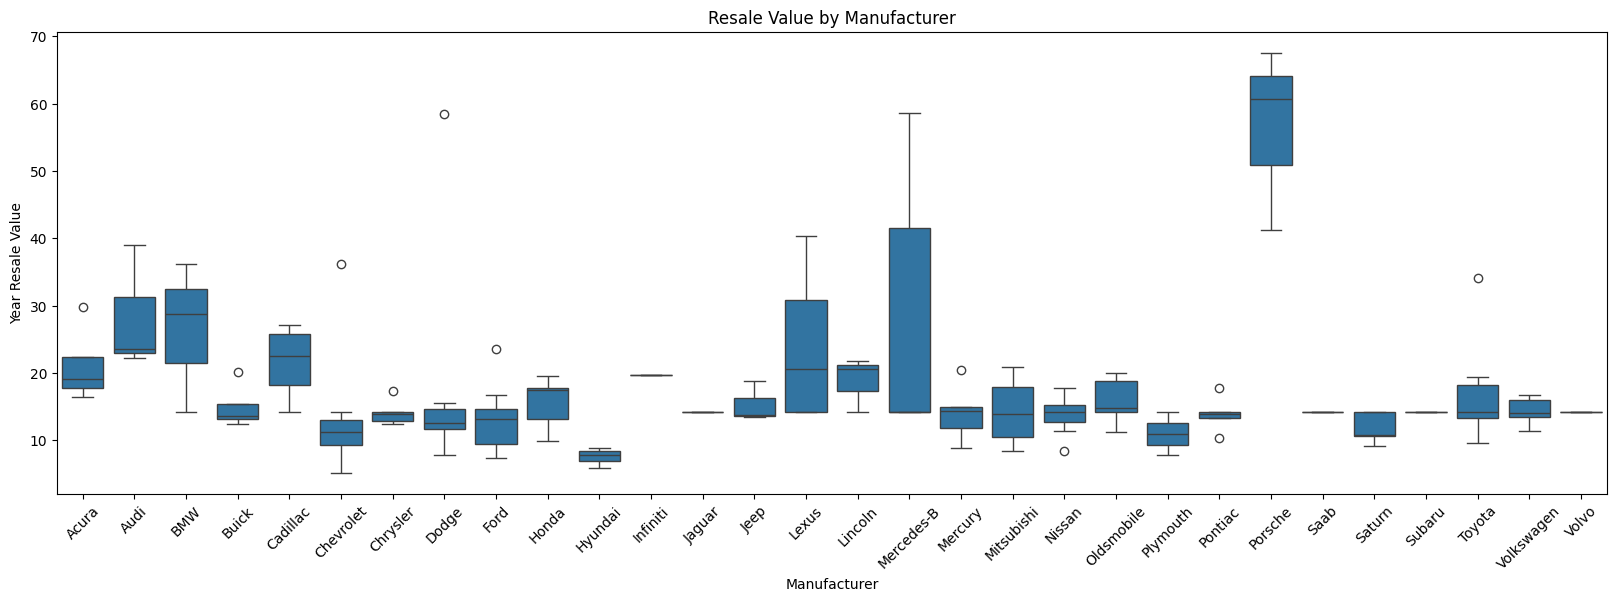

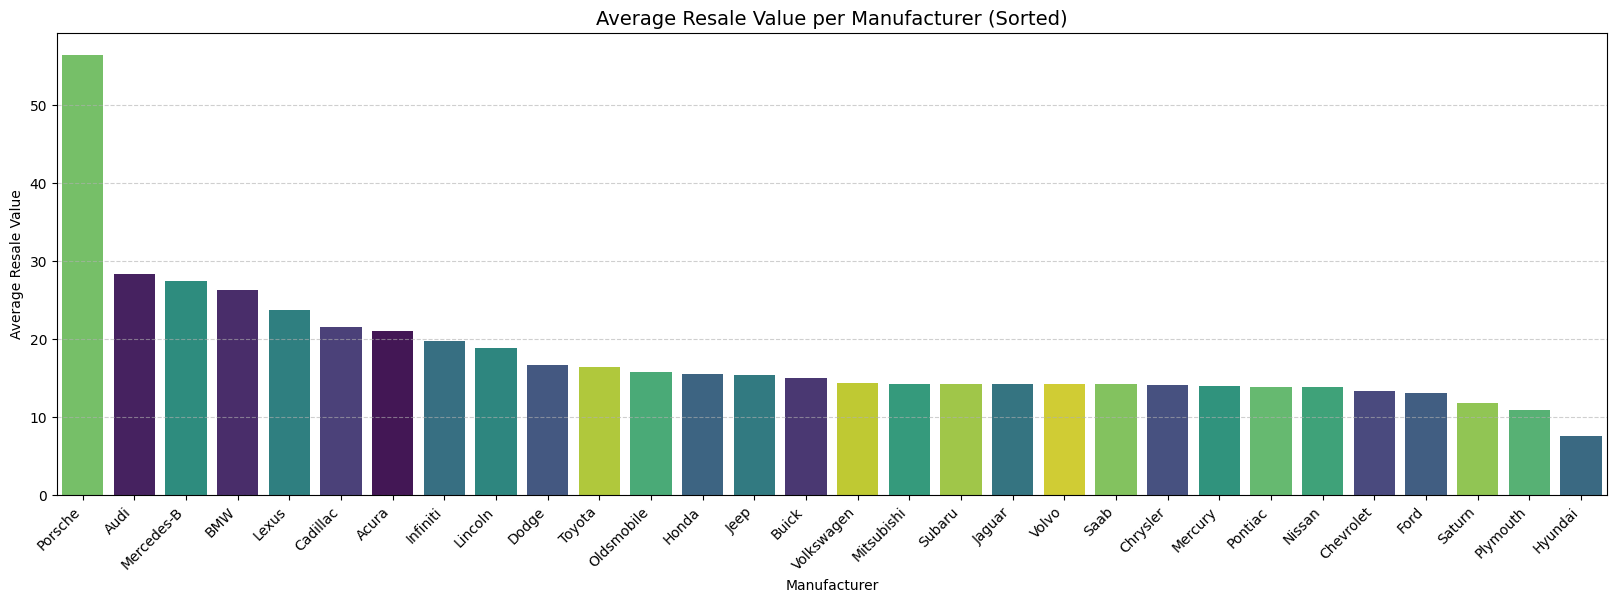

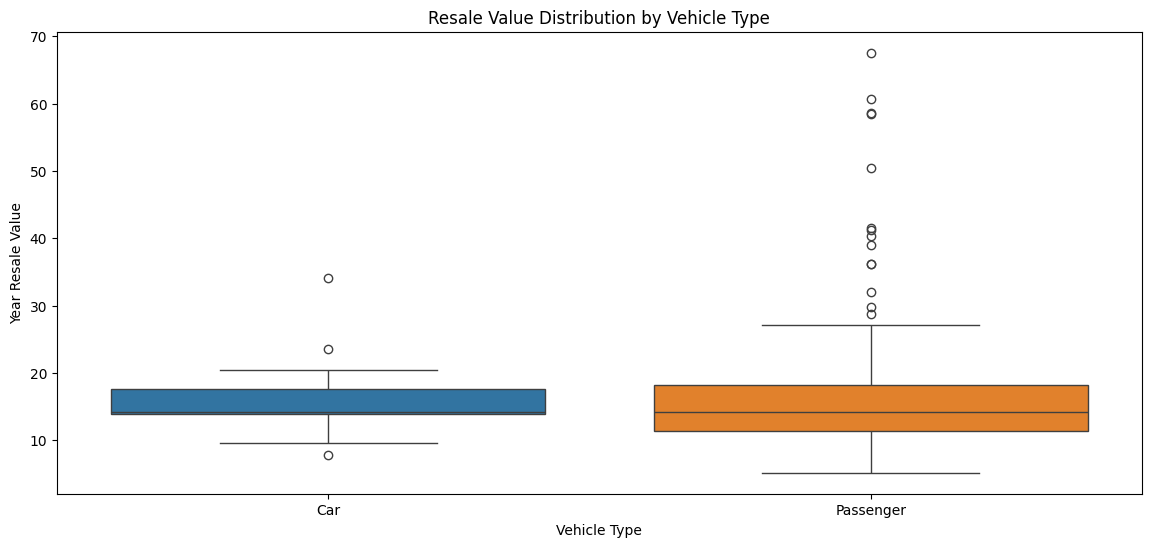

/var/folders/6k/b0rqkgcn77g39rb5g8zn55zc0000gn/T/ipykernel_42036/3257558549.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Vehicle_type', y='Year_resale_value', data=df, errorbar=None, palette='viridis' )


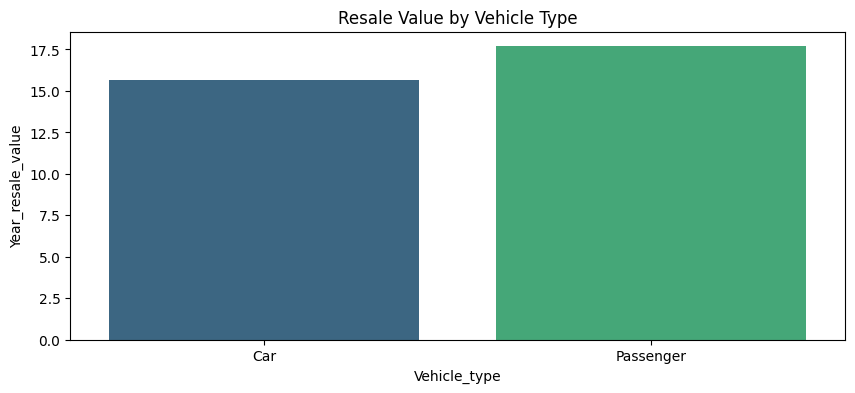

In [42]:
# Resales Analysis (Categorical Features)
# Does Manufacturer significantly influence Resales

# Manufacturer vs Resales (Boxplot)
plt.figure(figsize=(20,6))
sns.boxplot(x="Manufacturer", y="Year_resale_value", data=df)
plt.xticks(rotation=45)
plt.title("Resale Value by Manufacturer")
plt.xlabel("Manufacturer")
plt.ylabel("Year Resale Value")
plt.show()

# Which manufacturer dominates the resale values
# Average Resales Value per Manufacturer (Barplot)
plt.figure(figsize=(20,6))

# Aggregate and sort by sales (creates the small, sorted summary table)
manufacturer_resale_df = (df.groupby('Manufacturer', observed=True)['Year_resale_value'].mean().sort_values(ascending=False).reset_index())

# Extract the sorted list of Manufacturer names for explicit order
manufacturer_order_list = manufacturer_resale_df['Manufacturer']

# Plotting the PRE-SORTED DataFrame with explicit order
sns.barplot(
    data=manufacturer_resale_df,
    x="Manufacturer",
    y="Year_resale_value",
    order=manufacturer_order_list, # GUARANTEES THE SORTING
    hue="Manufacturer", 
    legend=False,
    palette='viridis' 
)

plt.xticks(rotation=45, ha='right')
plt.title("Average Resale Value per Manufacturer (Sorted)", fontsize=14)
plt.xlabel("Manufacturer")
plt.ylabel("Average Resale Value")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Are resales linked to Vehicle_Type? (Boxplot for ReSale Distribution)
# Vehicle Type vs Sales (Boxplot)
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x="Vehicle_type", y="Year_resale_value", hue="Vehicle_type")
plt.xticks()
plt.title("Resale Value Distribution by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Year Resale Value")
plt.show()

# Vehicle Type vs Resale Value (Barplot)
plt.figure(figsize=(10,4))
sns.barplot(x='Vehicle_type', y='Year_resale_value', data=df, errorbar=None, palette='viridis' )
plt.title(f"Resale Value by Vehicle Type")
plt.show()

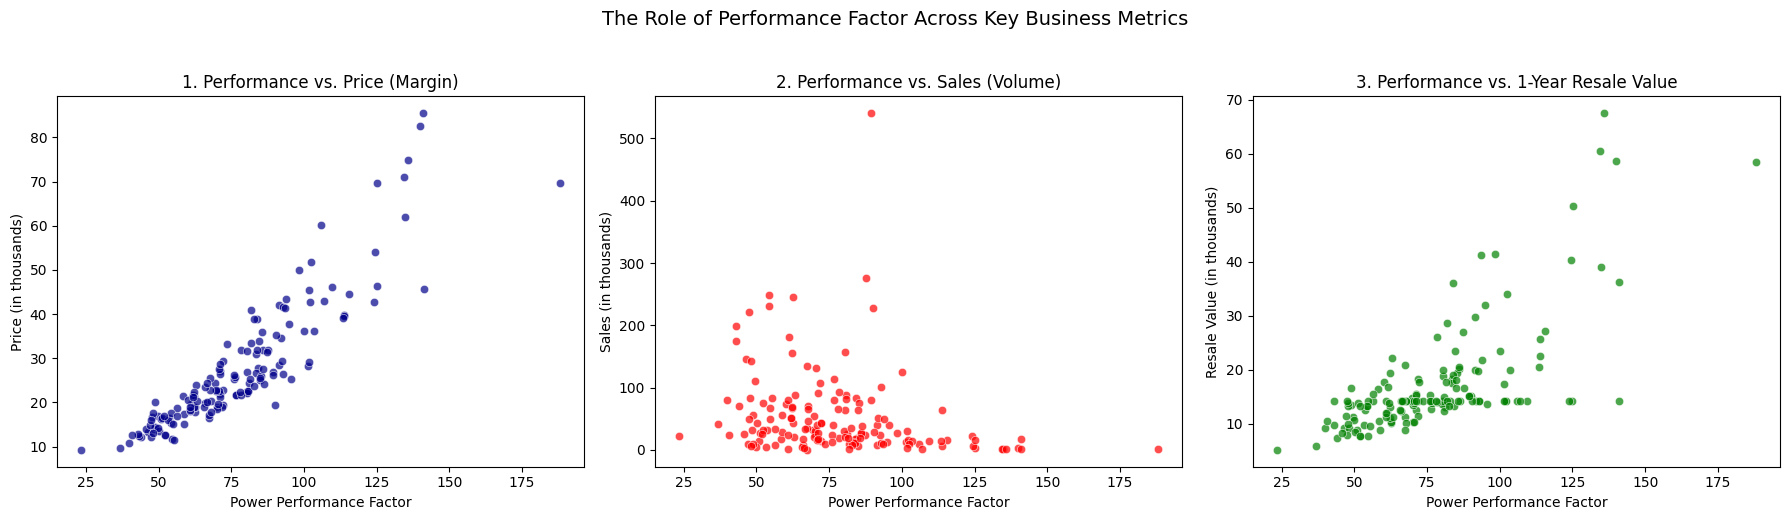

In [26]:
# ----------------------------------------------------------------------
# ANALYSIS: Power_perf_factor vs. Key Business Metrics
# Addresses: Performance correlation with Price, Sales, and Resale.
# ----------------------------------------------------------------------


fig, ax = plt.subplots(1, 3, figsize=(18, 5))
plt.suptitle("The Role of Performance Factor Across Key Business Metrics", fontsize=14, y=1.03)

# Plot 1: Price (Margin)
sns.scatterplot(x='Power_perf_factor', y='Price_in_thousands', data=df, ax=ax[0], color='darkblue', alpha=0.7)
ax[0].set_title("1. Performance vs. Price (Margin)")
ax[0].set_xlabel("Power Performance Factor")
ax[0].set_ylabel("Price (in thousands)")


# Plot 2: Sales (Volume)
sns.scatterplot(x='Power_perf_factor', y='Sales_in_thousands', data=df, ax=ax[1], color='red', alpha=0.7)
ax[1].set_title("2. Performance vs. Sales (Volume)")
ax[1].set_xlabel("Power Performance Factor")
ax[1].set_ylabel("Sales (in thousands)")


# Plot 3: Resale Value (Retention)
sns.scatterplot(x='Power_perf_factor', y='Year_resale_value', data=df, ax=ax[2], color='green', alpha=0.7)
ax[2].set_title("3. Performance vs. 1-Year Resale Value")
ax[2].set_xlabel("Power Performance Factor")
ax[2].set_ylabel("Resale Value (in thousands)")


plt.tight_layout() # Adjust layout to make room for suptitle
plt.show()


--- CORRELATION HEATMAP FOR ALL NUMERIC COLUMNS ---


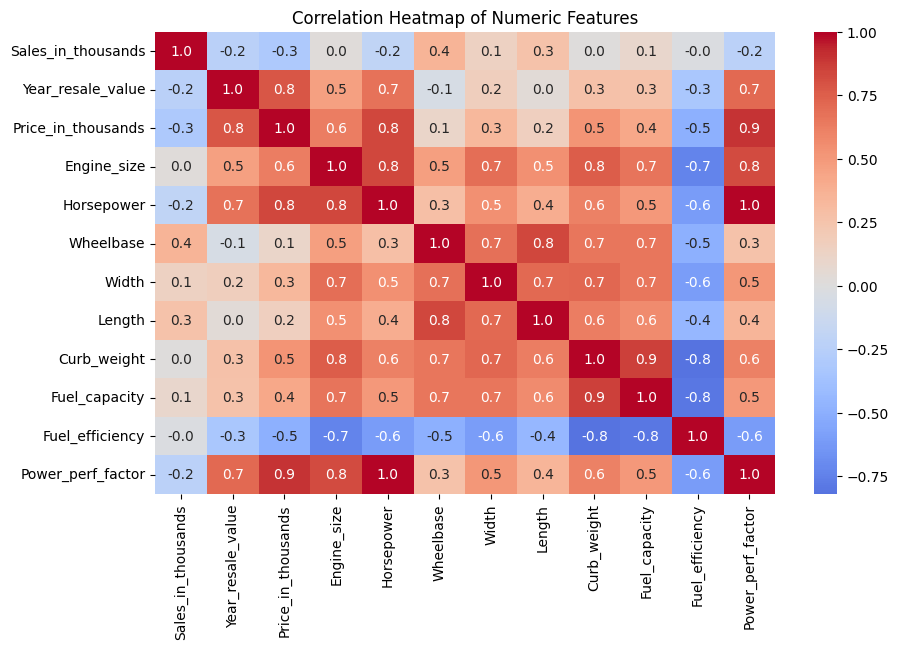

In [27]:
print("--- CORRELATION HEATMAP FOR ALL NUMERIC COLUMNS ---")
# Correlation Heatmap for numeric columns

numeric_cols = df.select_dtypes(include=np.number).columns
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", center=0, fmt='.1f');
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


Selected price-driving features: ['Year_resale_value', 'Engine_size', 'Horsepower', 'Curb_weight', 'Fuel_efficiency', 'Power_perf_factor']


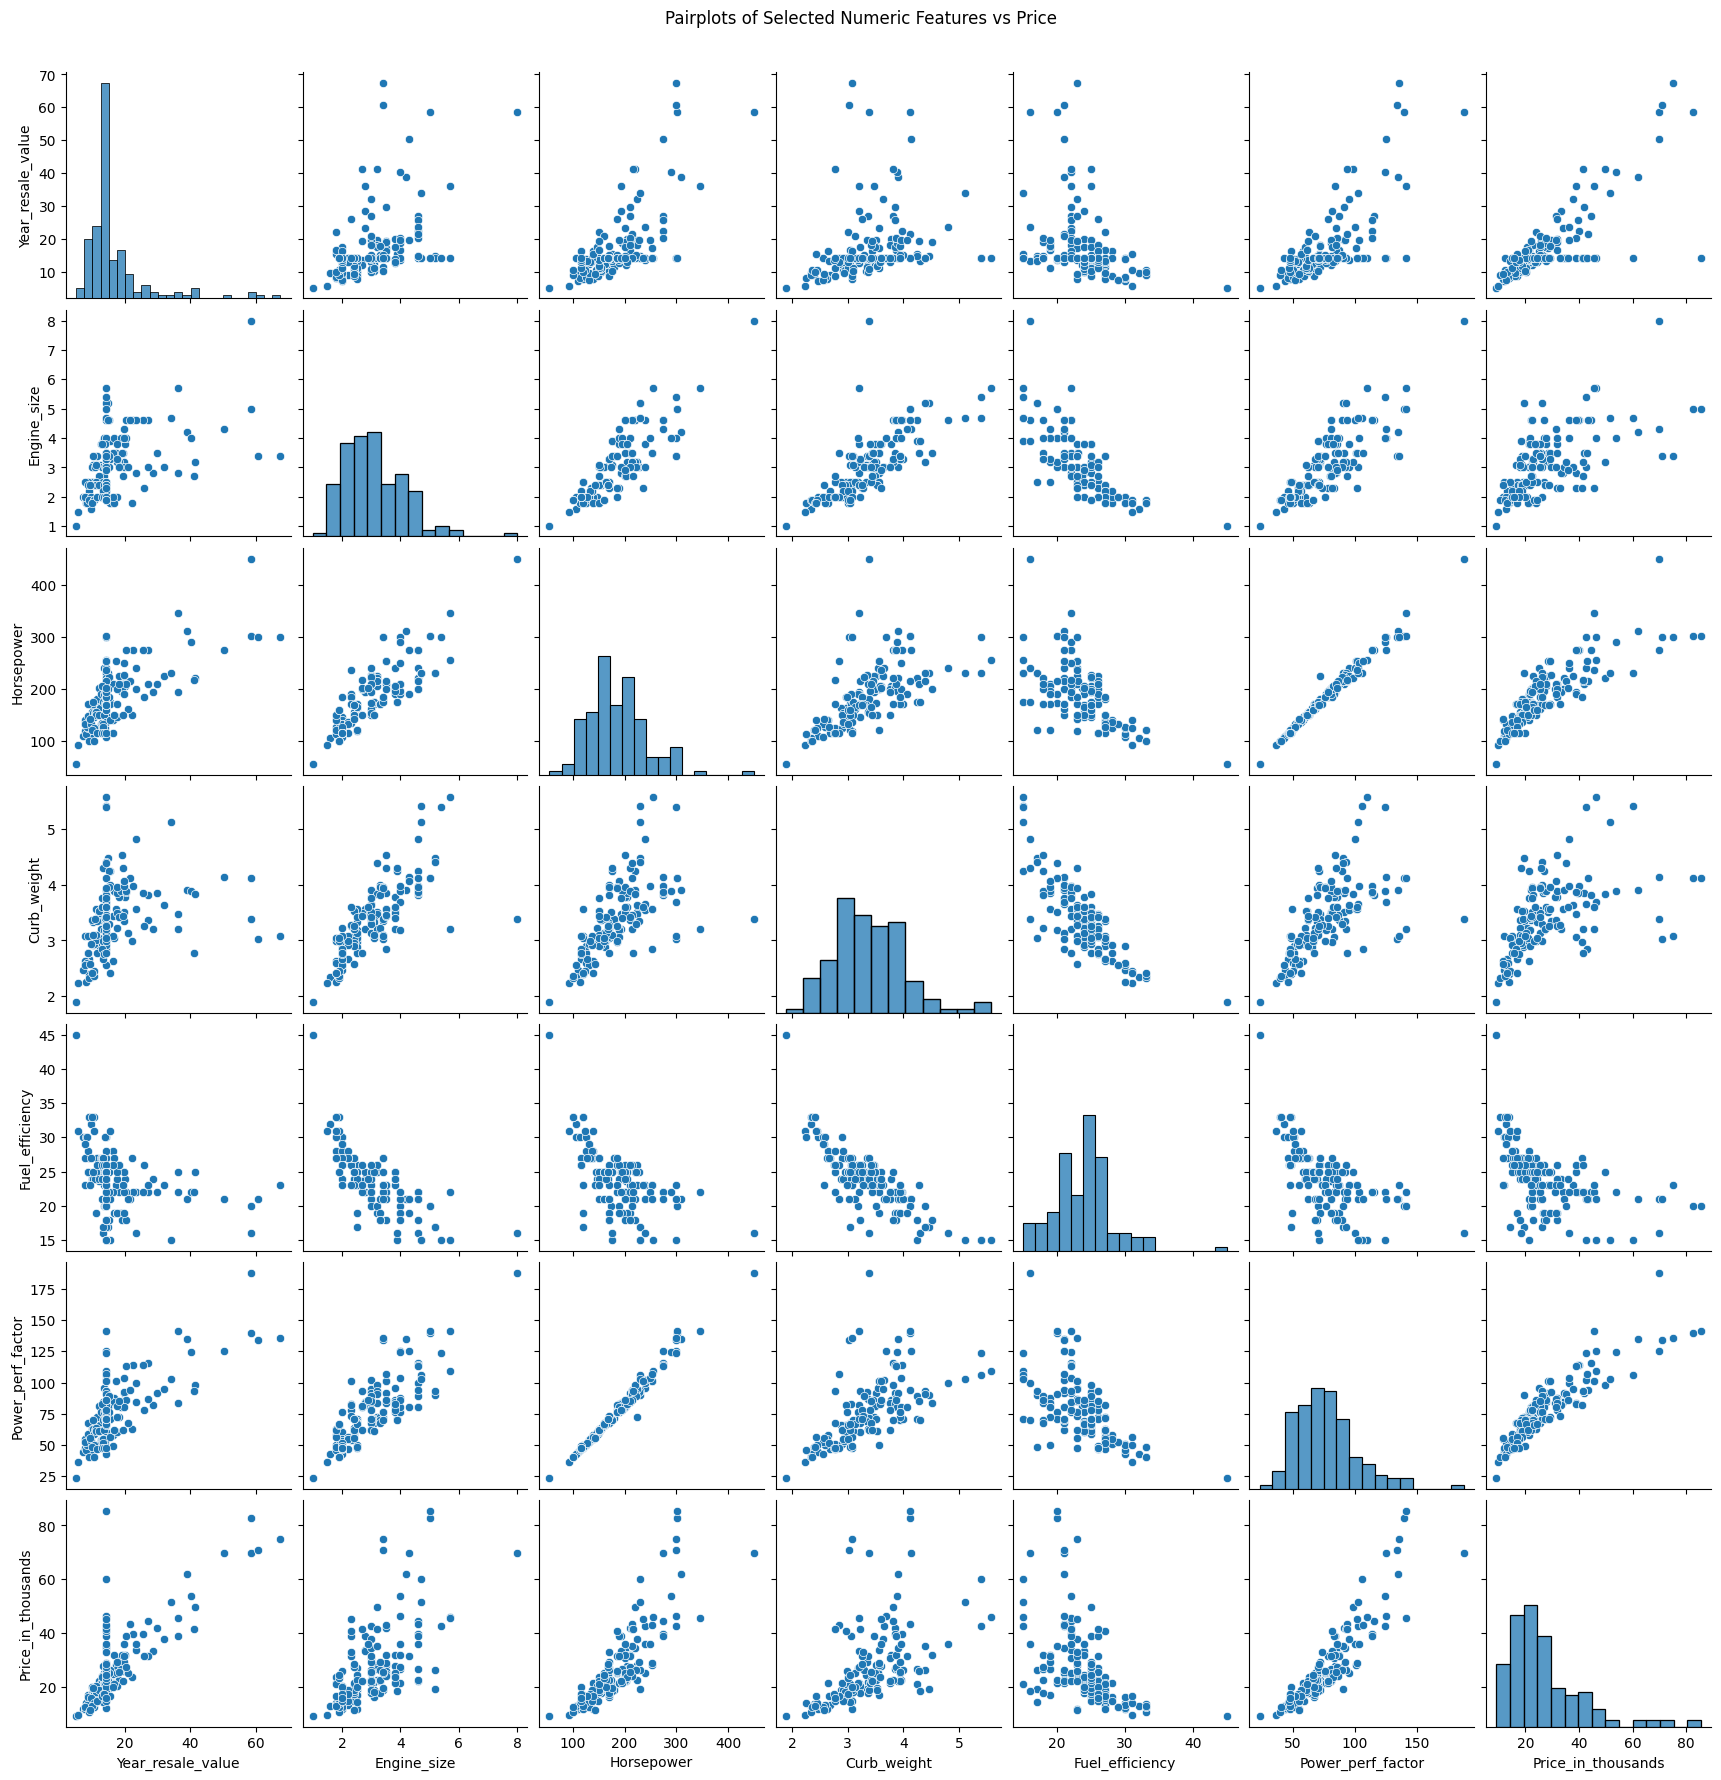

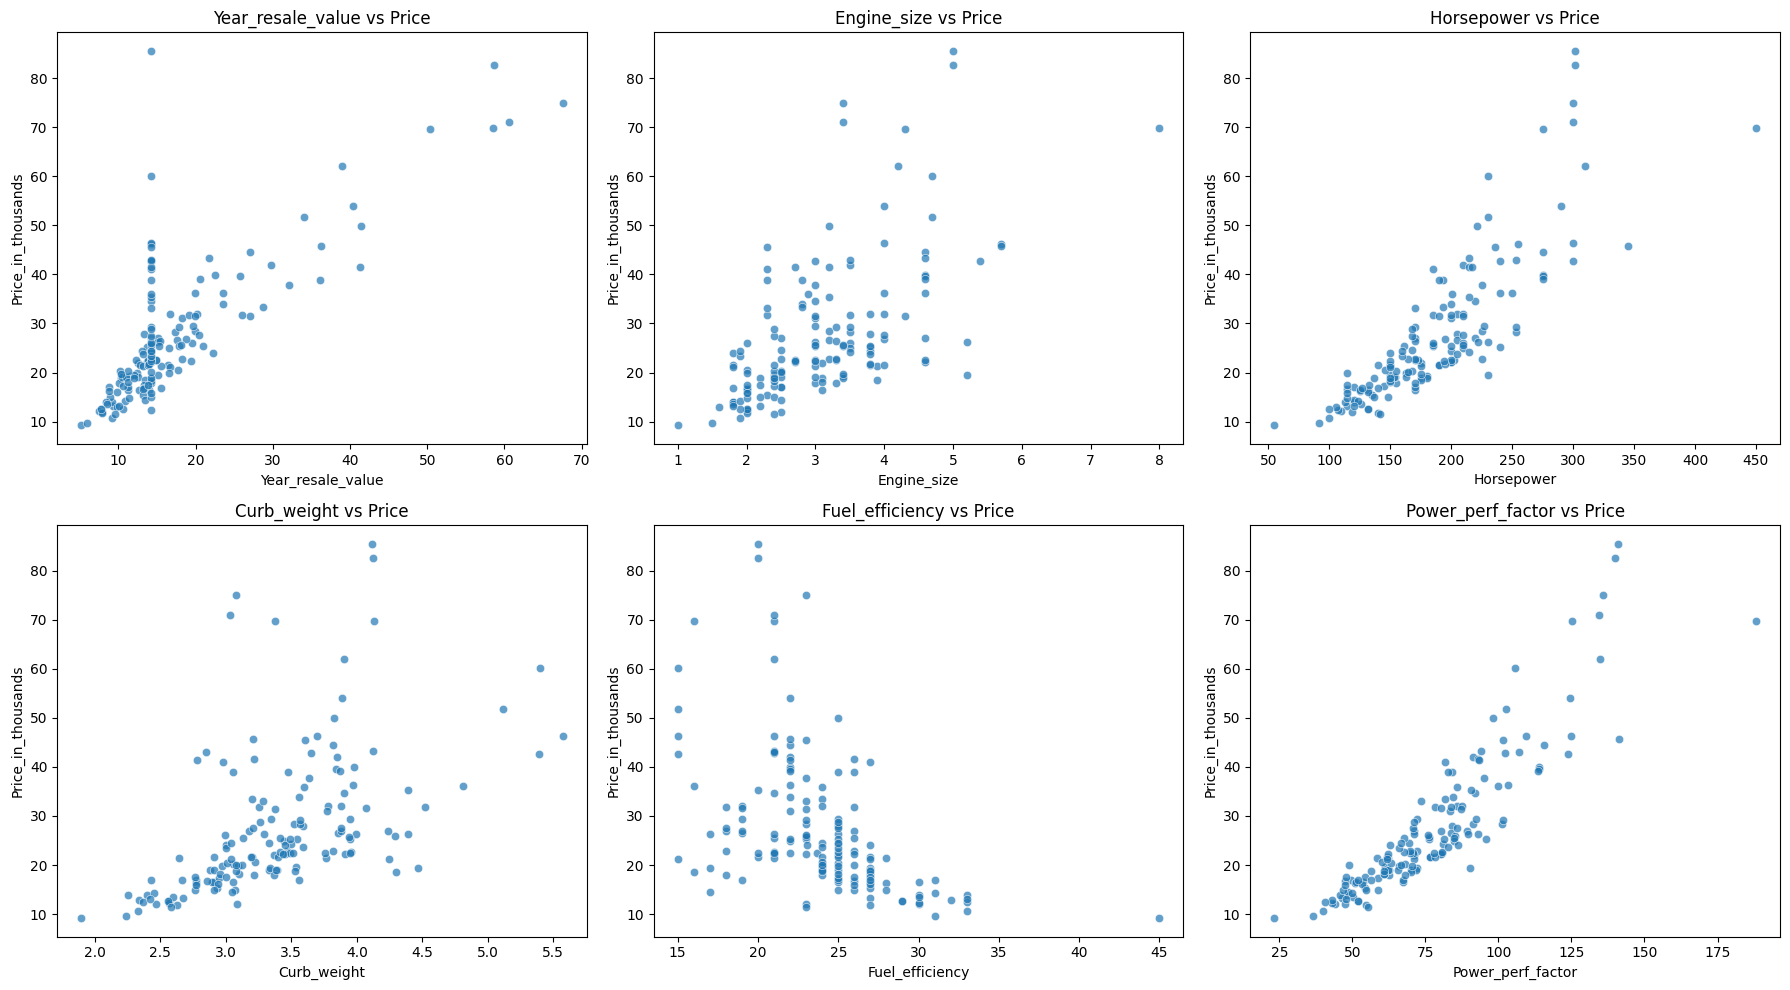

In [28]:
# Factors influencing car price

# Step 1: Numeric features including target Price
numeric_cols = df.select_dtypes(include=np.number).columns

# Step 2: Correlation matrix
corr_matrix = df[numeric_cols].corr().round(1)

# Step 3: Extract correlations with Price
price_corr = corr_matrix["Price_in_thousands"].drop("Price_in_thousands")

# Step 4: Select features with |correlation| > 0.5
selected_price_features = price_corr[price_corr.abs() >= 0.5].index.tolist()

print("Selected price-driving features:", selected_price_features)

# Pairplot of selected features + Price
sns.pairplot(df[selected_price_features + ["Price_in_thousands"]])
plt.suptitle("Pairplots of Selected Numeric Features vs Price", y=1.02)
plt.show()

# Scatterplots: all selected features vs Price in one figure
n_features = len(selected_price_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols  # auto-calc rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()

for i, feature in enumerate(selected_price_features):
    sns.scatterplot(x=feature, y="Price_in_thousands", data=df, ax=axes[i], alpha=0.7)
    axes[i].set_title(f"{feature} vs Price")

# Hide unused axes (if features < grid size)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

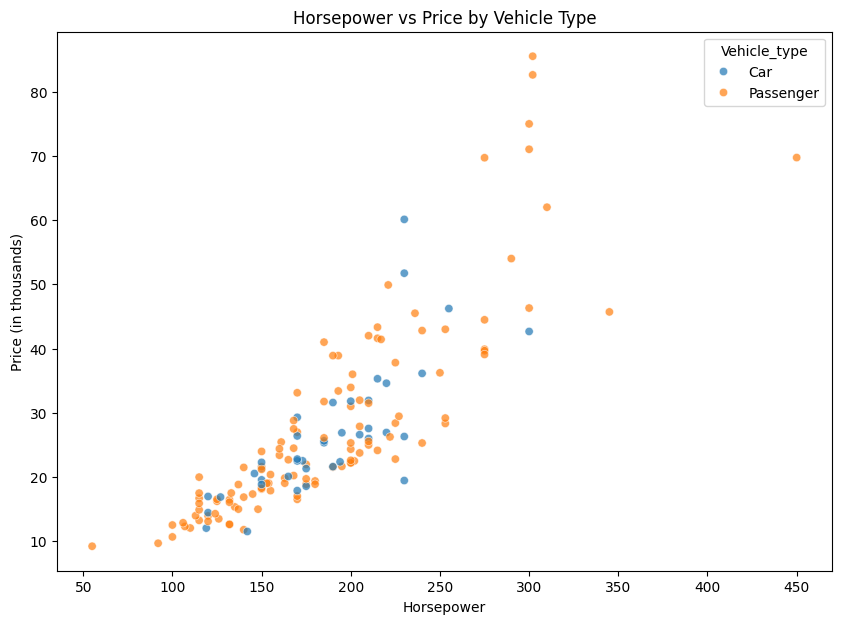

In [29]:
# How does Horsepower relate to Price
# Scatterplot: Horsepower vs Price by Vehicle_Type

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='Horsepower', y='Price_in_thousands', hue='Vehicle_type', alpha=0.7)
plt.title("Horsepower vs Price by Vehicle Type")
plt.xlabel("Horsepower")
plt.ylabel("Price (in thousands)")
plt.show()

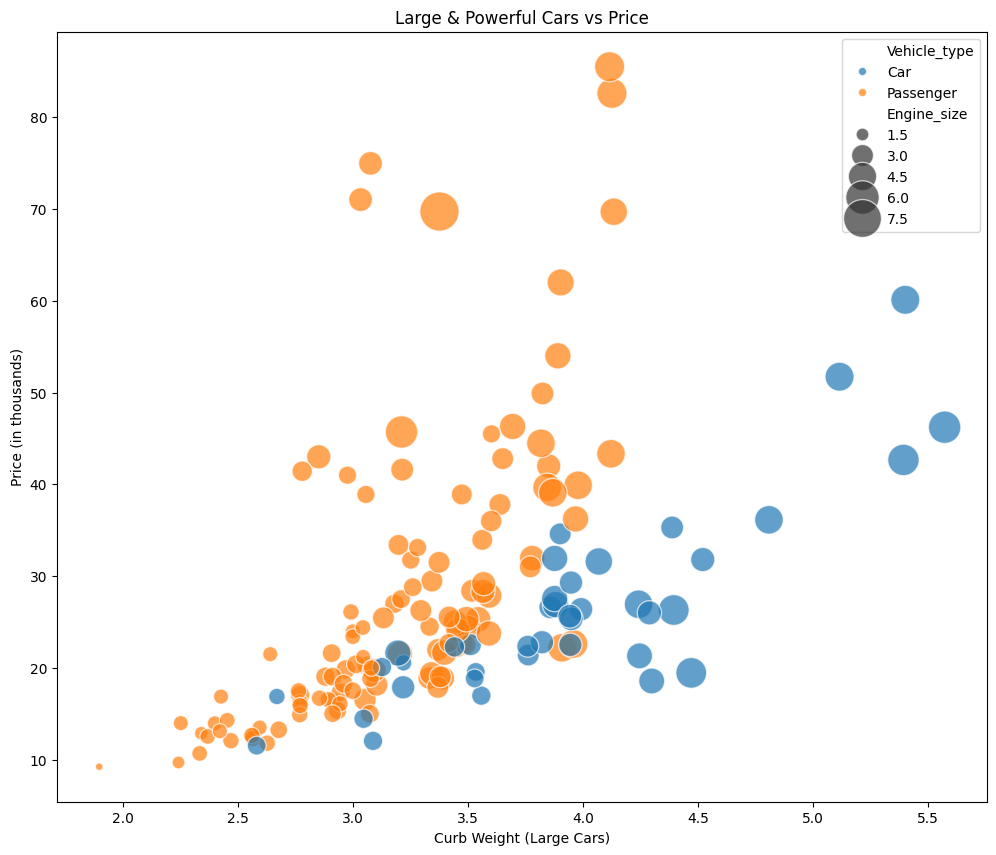

In [30]:
# Do large/more powerful cars command higher prices?
plt.figure(figsize=(12,10))

sns.scatterplot(
    data=df,
    x='Curb_weight',           # Large
    y='Price_in_thousands',    # Price
    size='Engine_size',        # Powerful
    hue='Vehicle_type',        # Vehicle Type for color
    alpha=0.7,
    sizes=(30, 800)            # min/max bubble size
)

plt.title("Large & Powerful Cars vs Price")
plt.xlabel("Curb Weight (Large Cars)")
plt.ylabel("Price (in thousands)")
plt.show()

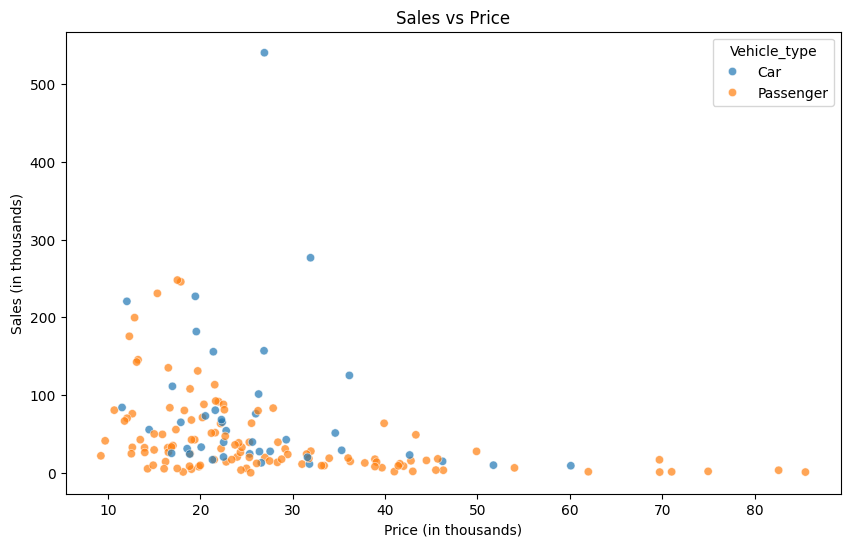

In [31]:
# What is the relationship between Price and Sales

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Price_in_thousands', y='Sales_in_thousands', hue='Vehicle_type',alpha=0.7)
plt.title("Sales vs Price")
plt.xlabel("Price (in thousands)")
plt.ylabel("Sales (in thousands)")
plt.show()

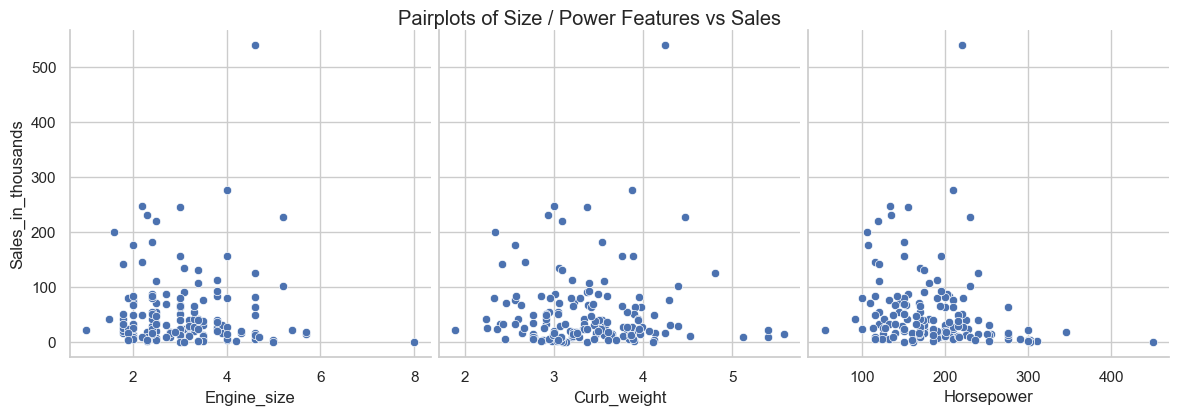

In [47]:
# Do larger / more powerful cars sell better than smaller ones?

# Drop rows with missing numeric data
df_sales = df[["Sales_in_thousands", "Engine_size", "Curb_weight", 
               "Horsepower", "Price_in_thousands"]].dropna()


# Optional: Pairplot of sales vs numeric features
sns.pairplot(df_sales, x_vars=["Engine_size","Curb_weight","Horsepower"], 
             y_vars=["Sales_in_thousands"], height=4, aspect=1, kind="scatter")
plt.suptitle("Pairplots of Size / Power Features vs Sales", y=1.02)
plt.show()


                     mean   median      max    min  count
Price_Category                                           
Economy         73.244036  42.6430  247.994  1.112     55
Mid-range       51.740416  30.6960  540.561  0.110     77
Premium         12.368650   9.4805   48.911  0.916     20
Luxury           1.852750   1.5730    3.311  0.954      4


/var/folders/6k/b0rqkgcn77g39rb5g8zn55zc0000gn/T/ipykernel_42036/781000356.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_summary = df.groupby("Price_Category")["Sales_in_thousands"].agg(["mean","median","max","min","count"])
/var/folders/6k/b0rqkgcn77g39rb5g8zn55zc0000gn/T/ipykernel_42036/781000356.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Price_Category", y="Sales_in_thousands", data=df, estimator=np.mean, ci=None)


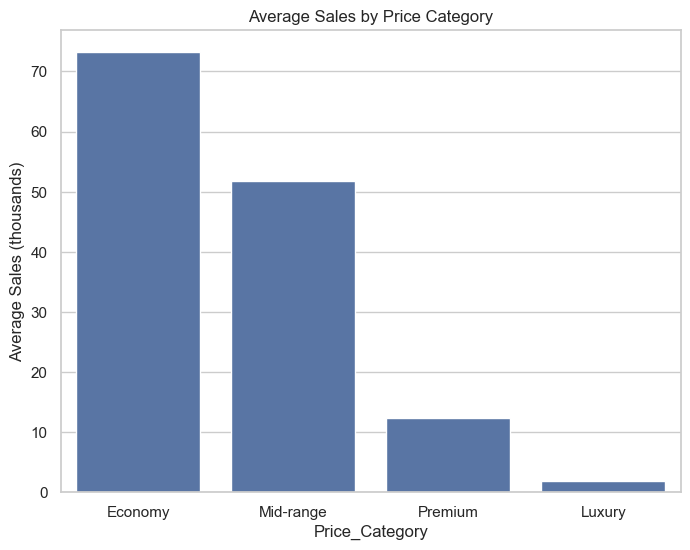

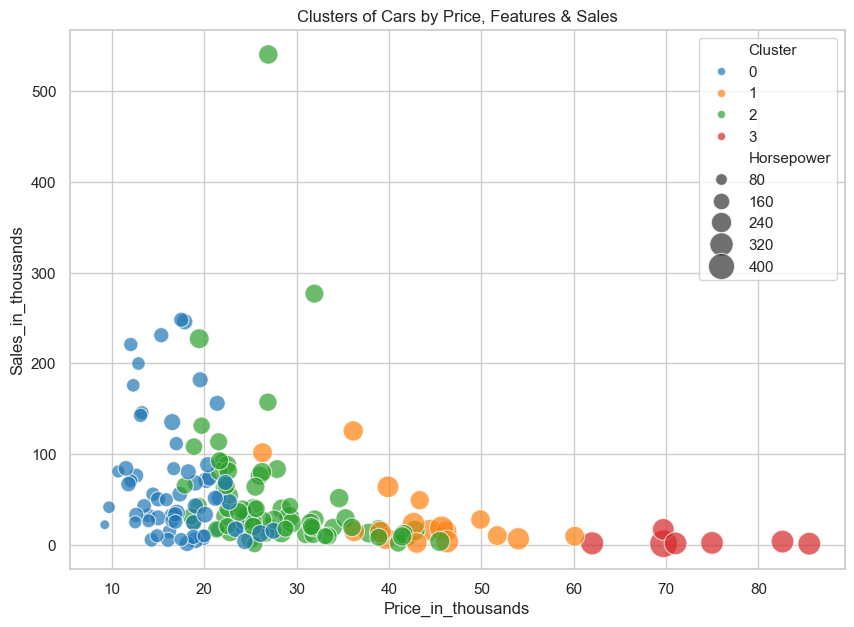

            Manufacturer           Model  Price_in_thousands  \
Cluster                                                        
0       137       Toyota           Camry              17.518   
        49          Ford          Taurus              17.885   
        58         Honda          Accord              15.350   
1       54          Ford      Expedition              36.135   
        44         Dodge         Durango              26.310   
        14      Cadillac         DeVille              39.895   
2       56          Ford        F-Series              26.935   
        52          Ford        Explorer              31.930   
        40         Dodge      Ram Pickup              19.460   
3       94    Mercedes-B         S-Class              69.700   
        95    Mercedes-B        SL-Class              82.600   
        126      Porsche  Carrera Cabrio              74.970   

             Sales_in_thousands  
Cluster                          
0       137             247.994  
 

/var/folders/6k/b0rqkgcn77g39rb5g8zn55zc0000gn/T/ipykernel_42036/781000356.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_models = df.groupby("Cluster").apply(lambda g: g.nlargest(3, "Sales_in_thousands")[["Manufacturer","Model","Price_in_thousands","Sales_in_thousands"]])


In [51]:
# Are higher-priced cars sold less than mid-range or economy cars?
# Sales by Price Category
df["Price_Category"] = pd.cut(df["Price_in_thousands"], bins=[0,20,40,70,150], labels=["Economy","Mid-range","Premium","Luxury"])

# Average and median sales by price category
sales_summary = df.groupby("Price_Category")["Sales_in_thousands"].agg(["mean","median","max","min","count"])
print(sales_summary)

# Optional: Bar plot of mean sales
plt.figure(figsize=(8,6))
sns.barplot(x="Price_Category", y="Sales_in_thousands", data=df, estimator=np.mean, ci=None)
plt.title("Average Sales by Price Category")
plt.ylabel("Average Sales (thousands)")
plt.show()

# Are there clusters of top-selling models by price and feature set?
# 5. Clusters / Top-Selling Models
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select relevant features for clustering
X = df[["Price_in_thousands","Sales_in_thousands","Horsepower","Engine_size"]].dropna()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

# Visualize clusters
plt.figure(figsize=(10,7))
sns.scatterplot(
    x="Price_in_thousands",
    y="Sales_in_thousands",
    hue="Cluster",
    size="Horsepower",
    data=df,
    palette="tab10",
    alpha=0.7,
    sizes=(50, 400)
)
plt.title("Clusters of Cars by Price, Features & Sales")
plt.show()

# Show top models in each cluster
top_models = df.groupby("Cluster").apply(lambda g: g.nlargest(3, "Sales_in_thousands")[["Manufacturer","Model","Price_in_thousands","Sales_in_thousands"]])
print(top_models)

